# Student Number: 190526948

# Please download the files 2004.csv, 2005.csv, airports.csv, carriers.csv, and plane-data.csv from https://doi.org/10.7910/DVN/HG7NV7
#Ensure that you have set your working directory to the location where the files are downloaded.


In [1]:
import sqlite3
import pandas as pd
import os

In [2]:
# IMPORTANT NOTE
# Note that your path to the database may be different
try:
    os.remove('F:/School/Year_3/ST2195/Course_Work/Data/airline2_python.db')
except OSError:
    pass

In [5]:
# Note that your path to the database may be different 
conn = sqlite3.connect('F:/School/Year_3/ST2195/Course_Work/Data/airline2_python.db')
# Note that your path to the data may be different 
airports = pd.read_csv("F:/School/Year_3/ST2195/Course_Work/Data/airports.csv")
carriers = pd.read_csv("F:/School/Year_3/ST2195/Course_Work/Data/carriers.csv")
planes = pd.read_csv("F:/School/Year_3/ST2195/Course_Work/Data/plane-data.csv")

In [6]:
airports.to_sql('airports', con = conn, index = False)
carriers.to_sql('carriers', con = conn, index = False)
planes.to_sql('planes', con = conn, index = False)

In [7]:
c = conn.cursor()

c.execute('''
CREATE TABLE ontime (
  Year int,
  Month int,
  DayofMonth int,
  DayOfWeek int,
  DepTime  int,
  CRSDepTime int,
  ArrTime int,
  CRSArrTime int,
  UniqueCarrier varchar(5),
  FlightNum int,
  TailNum varchar(8),
  ActualElapsedTime int,
  CRSElapsedTime int,
  AirTime int,
  ArrDelay int,
  DepDelay int,
  Origin varchar(3),
  Dest varchar(3),
  Distance int,
  TaxiIn int,
  TaxiOut int,
  Cancelled int,
  CancellationCode varchar(1),
  Diverted varchar(1),
  CarrierDelay int,
  WeatherDelay int,
  NASDelay int,
  SecurityDelay int,
  LateAircraftDelay int
)
''')

conn.commit()

In [8]:
for year in range(2004, 2006):
    print('Processing: ', year)
    ontime = pd.read_csv("F:/School/Year_3/ST2195/Course_Work/Data/"+str(year)+".csv")    
    ontime.to_sql('ontime', con = conn, if_exists = 'append', index = False)
conn.commit()

Processing:  2004
Processing:  2005


In [9]:
ontime_db = pd.read_sql('SELECT * FROM ontime', conn)

In [10]:
#removed unused columns to make dataset smaller
ontime_db = ontime_db.drop(columns=['ActualElapsedTime','FlightNum', 'CRSElapsedTime', 'AirTime','Distance',
                                    'TaxiIn', 'TaxiOut', 'Diverted','CancellationCode', 'CarrierDelay',
                                    'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'])

In [11]:
#drop flights that have been cancelled to make sample size smaller
ontime_db = ontime_db[ontime_db['Cancelled'] != 1]

In [12]:
import numpy as np
ontime_db['Delay'] = np.where(ontime_db['DepDelay'] >= 15, 1, 0 )
flight_sum = ontime_db
flight_sum_delay = ontime_db[ontime_db['Delay']!= 0]
flight_sum['CRSDepHour'] = flight_sum.CRSDepTime // 100 % 24
flight_sum_delay['CRSDepHour'] = flight_sum.CRSDepTime // 100 % 24

<ipython-input-12-37660b57e052>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_sum_delay['CRSDepHour'] = flight_sum.CRSDepTime // 100 % 24


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Q1 Best Time of the Day to Fly to Minimise Delays

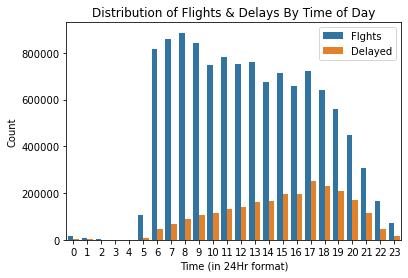

In [14]:
ax=sns.countplot(x='CRSDepHour', hue='Delay', data=flight_sum)
ax.set_ylabel('Count')
ax.set_xlabel('Time (in 24Hr format)')
ax.title.set_text("Distribution of Flights & Delays By Time of Day")
L = plt.legend()
L.get_texts()[0].set_text('Flghts')
L.get_texts()[1].set_text('Delayed')

# Q1 Best Day of Week to Fly to Minimise Delays

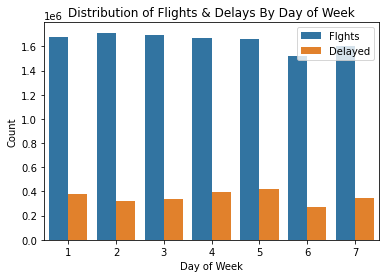

In [16]:
ax=sns.countplot(x='DayOfWeek', hue='Delay', data=flight_sum)
ax.set_ylabel('Count')
ax.set_xlabel('Day of Week')
ax.title.set_text("Distribution of Flights & Delays By Day of Week")
L = plt.legend()
L.get_texts()[0].set_text('Flghts')
L.get_texts()[1].set_text('Delayed')

# Q1 Best Month to Fly to Minimise Delays

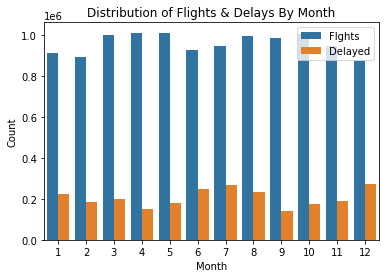

In [17]:
ax=sns.countplot(x='Month', hue='Delay', data=flight_sum)
ax.set_ylabel('Count')
ax.set_xlabel('Month')
ax.title.set_text("Distribution of Flights & Delays By Month")
L = plt.legend()
L.get_texts()[0].set_text('Flghts')
L.get_texts()[1].set_text('Delayed')

#Q2 Do older planes suffer more delays

In [18]:
planes_df1=planes[planes['type'].isnull()==False]
older_planes_delay = ontime_db.merge(planes_df1[['tailnum','year']],how='left',left_on='TailNum',right_on='tailnum')

In [19]:
from scipy.stats import chisquare
import numpy as np

In [20]:
older_planes_delay.replace([np.inf, -np.inf], np.nan, inplace=True)
older_planes_delay = older_planes_delay.fillna(0)
older_planes_delay.loc[(older_planes_delay!=0).any(1)]
older_planes_delay['ArrDelay'] = older_planes_delay['ArrDelay'].astype(int)
older_planes_delay['Delayed_Total']= np.where((older_planes_delay['DepDelay']>=15) |(older_planes_delay['ArrDelay']>=15),1,0)
chi,p =chisquare(np.array(older_planes_delay.groupby(['year'])['Delayed_Total'].sum()))

In [21]:
print("P value {:.6f}".format(p))
if p <0.05:
  print("There sufficient evidence to reject null hypothesis")
else:
  print("There  no sufficient evidence to reject null hypothesis")

P value 0.000000
There sufficient evidence to reject null hypothesis


# Q3 How does the number of people flying between different locations change over time?

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Set the colour palette to colour-blind friendly
sns.reset_orig()
my_palette = sns.color_palette("colorblind") # variations of default palette: deep, muted, pastel, bright, dark, colorblind. 
plt.style.use('seaborn-colorblind')
# plt.style.available

In [24]:
q1_2004_db = ontime_db.loc[(ontime_db['Year']==2004) & (ontime_db['Month'].between(1,3,inclusive = True)) & (ontime_db['Origin']=='ATL')]
q2_2004_db = ontime_db.loc[(ontime_db['Year']==2004) & (ontime_db['Month'].between(4,6,inclusive = True)) & (ontime_db['Origin']=='ATL')]
q3_2004_db = ontime_db.loc[(ontime_db['Year']==2004) & (ontime_db['Month'].between(7,9,inclusive = True)) & (ontime_db['Origin']=='ATL')]
q4_2004_db = ontime_db.loc[(ontime_db['Year']==2004) & (ontime_db['Month'].between(10,12,inclusive = True)) & (ontime_db['Origin']=='ATL')]
q1_2005_db = ontime_db.loc[(ontime_db['Year']==2005) & (ontime_db['Month'].between(1,3,inclusive = True)) & (ontime_db['Origin']=='ATL')]
q2_2005_db = ontime_db.loc[(ontime_db['Year']==2005) & (ontime_db['Month'].between(4,6,inclusive = True)) & (ontime_db['Origin']=='ATL')]
q3_2005_db = ontime_db.loc[(ontime_db['Year']==2005) & (ontime_db['Month'].between(7,9,inclusive = True)) & (ontime_db['Origin']=='ATL')]
q4_2005_db = ontime_db.loc[(ontime_db['Year']==2005) & (ontime_db['Month'].between(10,12,inclusive = True)) & (ontime_db['Origin']=='ATL')]


In [25]:
q1_2004 = (q1_2004_db.Dest.value_counts()).head(10)
q2_2004 = (q2_2004_db.Dest.value_counts()).head(10)
q3_2004 = (q3_2004_db.Dest.value_counts()).head(10)
q4_2004 = (q4_2004_db.Dest.value_counts()).head(10)
q1_2005 = (q1_2005_db.Dest.value_counts()).head(10)
q2_2005 = (q2_2005_db.Dest.value_counts()).head(10)
q3_2005 = (q3_2005_db.Dest.value_counts()).head(10)
q4_2005 = (q4_2005_db.Dest.value_counts()).head(10)

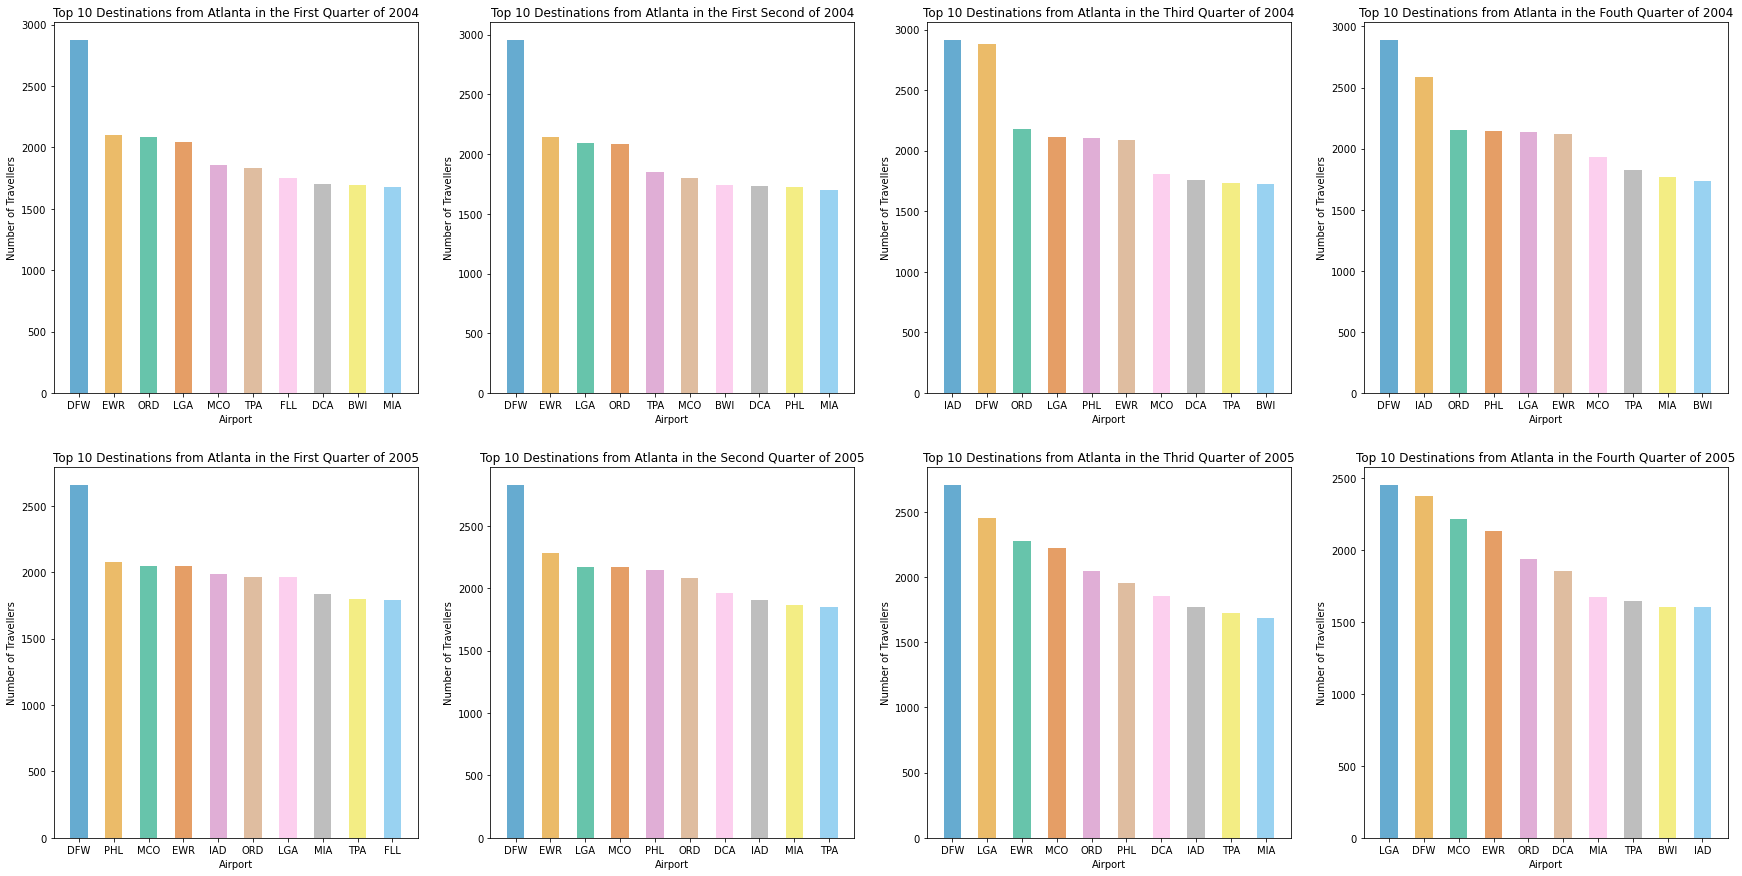

In [26]:
fig, ax = plt.subplots(2, 4, figsize=(30, 15))
ax[0][0].bar(q1_2004.index, q1_2004.values, alpha = 0.6,width = 0.5, color = my_palette)
ax[0][0].set_ylabel('Number of Travellers')
ax[0][0].set_xlabel('Airport')
ax[0][0].title.set_text("Top 10 Destinations from Atlanta in the First Quarter of 2004")

ax[0][1].bar(q2_2004.index, q2_2004.values, alpha = 0.6,width = 0.5, color = my_palette)
ax[0][1].set_ylabel('Number of Travellers')
ax[0][1].set_xlabel('Airport')
ax[0][1].title.set_text("Top 10 Destinations from Atlanta in the First Second of 2004")

ax[0][2].bar(q3_2004.index, q3_2004.values, alpha = 0.6,width = 0.5, color = my_palette)
ax[0][2].set_ylabel('Number of Travellers')
ax[0][2].set_xlabel('Airport')
ax[0][2].title.set_text("Top 10 Destinations from Atlanta in the Third Quarter of 2004")

ax[0][3].bar(q4_2004.index, q4_2004.values, alpha = 0.6,width = 0.5, color = my_palette)
ax[0][3].set_ylabel('Number of Travellers')
ax[0][3].set_xlabel('Airport')
ax[0][3].title.set_text("Top 10 Destinations from Atlanta in the Fouth Quarter of 2004")

ax[1][0].bar(q1_2005.index, q1_2005.values, alpha = 0.6,width = 0.5, color = my_palette)
ax[1][0].set_ylabel('Number of Travellers')
ax[1][0].set_xlabel('Airport')
ax[1][0].title.set_text("Top 10 Destinations from Atlanta in the First Quarter of 2005")

ax[1][1].bar(q2_2005.index, q2_2005.values, alpha = 0.6,width = 0.5, color = my_palette)
ax[1][1].set_ylabel('Number of Travellers')
ax[1][1].set_xlabel('Airport')
ax[1][1].title.set_text("Top 10 Destinations from Atlanta in the Second Quarter of 2005")

ax[1][2].bar(q3_2005.index, q3_2005.values, alpha = 0.6,width = 0.5, color = my_palette)
ax[1][2].set_ylabel('Number of Travellers')
ax[1][2].set_xlabel('Airport')
ax[1][2].title.set_text("Top 10 Destinations from Atlanta in the Thrid Quarter of 2005")

ax[1][3].bar(q4_2005.index, q4_2005.values, alpha = 0.6,width = 0.5, color = my_palette)
ax[1][3].set_ylabel('Number of Travellers')
ax[1][3].set_xlabel('Airport')
ax[1][3].title.set_text("Top 10 Destinations from Atlanta in the Fourth Quarter of 2005")

plt.show()

# Q4 Can you detect cascading failures as delays in one airport create delays in others?

In [28]:
ontime_db['Dep_Delay_True'] = np.where(ontime_db['DepDelay'] >= 15, 1, 0 )
ontime_db['Arr_Delay_True'] = np.where(ontime_db['ArrDelay'] >= 15, 1, 0 )
ontime_db.head

ontime_db_2004 = ontime_db[ontime_db['Year']!=2005]
ontime_db_2004 = ontime_db_2004[['Year','Month','DayofMonth','DepTime','CRSDepTime','ArrTime','CRSArrTime','UniqueCarrier','TailNum','Origin','Dest','Arr_Delay_True','Dep_Delay_True']]


ontime_db_2004 = ontime_db_2004[ontime_db_2004['UniqueCarrier']=='UA']
ontime_db_2004 = ontime_db_2004.sort_values(by=['Month','DayofMonth','UniqueCarrier','TailNum','CRSDepTime'])